# Deep Bioinformatics project

In [0]:
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import torch
import pickle as pkl
import time
from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Dropout, BatchNorm1d, LSTM
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

## data import

## Use cuda

In [2]:
torch.cuda.empty_cache()

use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

Running GPU.


## Data (Penn Treebank)

In [10]:
from torchtext import data
from torchtext import datasets
from torchtext.vocab import GloVe
def tokenize(lines):
  return [line for line in lines]
# Approach 1:
# set up fields
TEXT = data.Field(lower=True,tokenize=tokenize, batch_first=True)

# make splits for data
train, valid, test = datasets.PennTreebank.splits(TEXT)

# print information about the data
print('train.fields', train.fields)
print('len(train)', len(train))
print('vars(train[0])', vars(train[0])['text'][0:10])

# build the vocabulary
TEXT.build_vocab(train, vectors=GloVe(name='6B', dim=300)) # GloVe is a better version of Word2Vec, it is a general thing. 
# 100 for the dimension of the embedding is suitable. Better not to use GloVe as it is too general
# We will do embeddings also with the protein dataset

# print vocab information
print('len(TEXT.vocab)', len(TEXT.vocab))

vars(train[0])['text'] = vars(train[0])['text']
vars(valid[0])['text'] = vars(test[0])['text']
vars(test[0])['text'] = vars(test[0])['text']
# make iterator for splits
train_iter, valid_iter, test_iter = data.BPTTIterator.splits(
    #(train, valid, test), batch_size=3, bptt_len=30)
    (train, valid, test), batch_size=3, bptt_len=50)

# batch_size = number of sentences // bptt (back propagation through time) = number of words per sentence

# print batch information
batch = next(iter(train_iter))
print(vars(train[0])['text'][0:10])

train.fields {'text': <torchtext.data.field.Field object at 0x7fb12a31b128>}
len(train) 1
vars(train[0]) [' ', 'a', 'e', 'r', ' ', 'b', 'a', 'n', 'k', 'n']
len(TEXT.vocab) 51
[' ', 'a', 'e', 'r', ' ', 'b', 'a', 'n', 'k', 'n']


HM_LSTM

In [0]:
import torch
from torch.autograd import Function, Variable
import torch.nn.functional as Func
from torch.nn import Module, Parameter
import math
import time
import torch.optim as optim
import numpy
import torch.nn.functional as Func
import os
#from utils import reverse, batchify, get_batch, repackage_hidden, evaluatePTB

hidden_dim = 200
vocab_size = len(TEXT.vocab)
bptt_len = 30
embedding_size = 300
out_dim = 500
def repackage_hidden(h):
    if type(h) == Variable:
        return Variable(h.data)
    else:
        return tuple(repackage_hidden(v) for v in h)
def hard_sigm(a, x):
    temp = torch.div(torch.add(torch.mul(x, a), 1), 2.0)
    output = torch.clamp(temp, min=0, max=1)
    return output

class bound(Function):
    def forward(self, x):
        # forward : x -> output
        self.save_for_backward(x)
        output = x > 0.5
        return output.float()

    def backward(self, output_grad):
        # backward: output_grad -> x_grad
        x = self.saved_tensors
        x_grad = None

        if self.needs_input_grad[0]:
            x_grad = output_grad.clone()

        return x_grad

class masked_NLLLoss(Module):
    def __init__(self):
        super(masked_NLLLoss, self).__init__()

    def forward(self, cost, inputs, mask):
        # inputs.size = mask.size = batch_size
        # cost.size = batch_size * dict_size

        # The following version is too slow, deprecated now
        # loss = Variable(torch.zeros(inputs.size(0))).cuda()
        # for i in range(inputs.size(0)):
        #     loss[i] = - cost[i, inputs[i]] * mask[i]

        # The following version is much faster
        batch_size, dict_size = cost.size()
        cost_flat = cost.view(batch_size*dict_size)
        inputs_flat = torch.arange(0, inputs.size(0)).cuda().long()
        inputs_flat_idx = torch.mul(inputs_flat, dict_size) + inputs
        loss = -cost_flat[inputs_flat_idx] * mask
        return loss

class HM_LSTMCell(Module):
    def __init__(self, bottom_size, hidden_size, top_size, a, last_layer):
        super(HM_LSTMCell, self).__init__()
        self.bottom_size = bottom_size
        self.hidden_size = hidden_size
        self.top_size = top_size
        self.a = a
        self.last_layer = last_layer
        '''
        U_11 means the state transition parameters from layer l (current layer) to layer l
        U_21 means the state transition parameters from layer l+1 (top layer) to layer l
        W_01 means the state transition parameters from layer l-1 (bottom layer) to layer l
        '''
        self.U_11 = Parameter(torch.cuda.FloatTensor(4 * self.hidden_size + 1, self.hidden_size))
        if not self.last_layer:
            self.U_21 = Parameter(torch.cuda.FloatTensor(4 * self.hidden_size + 1, self.top_size))
        self.W_01 = Parameter(torch.cuda.FloatTensor(4 * self.hidden_size + 1, self.bottom_size))
        self.bias = Parameter(torch.cuda.FloatTensor(4 * self.hidden_size + 1))

        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for par in self.parameters():
            par.data.uniform_(-stdv, stdv)

    def forward(self, c, h_bottom, h, h_top, z, z_bottom):
        # h_bottom.size = bottom_size * batch_size
        s_recur = torch.mm(self.W_01, h_bottom)
        if not self.last_layer:
            s_topdown_ = torch.mm(self.U_21, h_top)
            s_topdown = z.expand_as(s_topdown_) * s_topdown_
        else:
            s_topdown = Variable(torch.zeros(s_recur.size()).cuda(), requires_grad=False).cuda()
        s_bottomup_ = torch.mm(self.U_11, h)
        s_bottomup = z_bottom.expand_as(s_bottomup_) * s_bottomup_

        f_s = s_recur + s_topdown + s_bottomup + self.bias.unsqueeze(1).expand_as(s_recur)
        # f_s.size = (4 * hidden_size + 1) * batch_size
        f = Func.sigmoid(f_s[0:self.hidden_size, :])  # hidden_size * batch_size
        i = Func.sigmoid(f_s[self.hidden_size:self.hidden_size*2, :])
        o = Func.sigmoid(f_s[self.hidden_size*2:self.hidden_size*3, :])
        g = Func.tanh(f_s[self.hidden_size*3:self.hidden_size*4, :])
        z_hat = hard_sigm(self.a, f_s[self.hidden_size*4:self.hidden_size*4+1, :])

        one = Variable(torch.ones(f.size()).cuda(), requires_grad=False)
        z = z.expand_as(f)
        z_bottom = z_bottom.expand_as(f)

        c_new = z * (i * g) + (one - z) * (one - z_bottom) * c + (one - z) * z_bottom * (f * c + i * g)
        h_new = z * o * Func.tanh(c_new) + (one - z) * (one - z_bottom) * h + (one - z) * z_bottom * o * Func.tanh(c_new)

        # if z == 1: (FLUSH)
        #     c_new = i * g
        #     h_new = o * Func.tanh(c_new)
        # elif z_bottom == 0: (COPY)
        #     c_new = c
        #     h_new = h
        # else: (UPDATE)
        #     c_new = f * c + i * g
        #     h_new = o * Func.tanh(c_new)

        z_new = bound()(z_hat)

        return h_new, c_new, z_new


class HM_LSTM(Module):
    def __init__(self, a, input_size, size_list):
        super(HM_LSTM, self).__init__()
        self.a = a
        self.input_size = input_size
        self.size_list = size_list

        self.cell_1 = HM_LSTMCell(self.input_size, self.size_list[0], self.size_list[1], self.a, False)
        self.cell_2 = HM_LSTMCell(self.size_list[0], self.size_list[1], None, self.a, True)

    def forward(self, inputs, hidden):
        # inputs.size = (batch_size, time steps, embed_size/input_size)
        time_steps = inputs.size(1)
        batch_size = inputs.size(0)

        if hidden == None:
            h_t1 = Variable(torch.zeros(self.size_list[0], batch_size).float().cuda(), requires_grad=False)
            c_t1 = Variable(torch.zeros(self.size_list[0], batch_size).float().cuda(), requires_grad=False)
            z_t1 = Variable(torch.zeros(1, batch_size).float().cuda(), requires_grad=False)
            h_t2 = Variable(torch.zeros(self.size_list[1], batch_size).float().cuda(), requires_grad=False)
            c_t2 = Variable(torch.zeros(self.size_list[1], batch_size).float().cuda(), requires_grad=False)
            z_t2 = Variable(torch.zeros(1, batch_size).float().cuda(), requires_grad=False)
        else:
            (h_t1, c_t1, z_t1, h_t2, c_t2, z_t2) = hidden
        z_one = Variable(torch.ones(1, batch_size).float().cuda(), requires_grad=False)

        h_1 = []
        h_2 = []
        z_1 = []
        z_2 = []
        for t in range(time_steps):
            h_t1, c_t1, z_t1 = self.cell_1(c=c_t1, h_bottom=inputs[:, t, :].t(), h=h_t1, h_top=h_t2, z=z_t1, z_bottom=z_one)
            h_t2, c_t2, z_t2 = self.cell_2(c=c_t2, h_bottom=h_t1, h=h_t2, h_top=None, z=z_t2, z_bottom=z_t1)  # 0.01s used
            h_1 += [h_t1.t()]
            h_2 += [h_t2.t()]
            z_1 += [z_t1.t()]
            z_2 += [z_t2.t()]

        hidden = (h_t1, c_t1, z_t1, h_t2, c_t2, z_t2)
        return torch.stack(h_1, dim=1), torch.stack(h_2, dim=1), torch.stack(z_1, dim=1), torch.stack(z_2, dim=1), hidden

class HM_Net(Module):
    def __init__(self, a, size_list, dict_size, embed_size):
        super(HM_Net, self).__init__()
        self.dict_size = dict_size
        self.size_list = size_list
        self.drop = nn.Dropout(p=0.5)
        self.embed_in = nn.Embedding(dict_size, embed_size)
        self.HM_LSTM = HM_LSTM(a, embed_size, size_list)
        self.weight = nn.Linear(size_list[0]+size_list[1], 2)
        self.embed_out1 = nn.Linear(size_list[0], dict_size)
        self.embed_out2 = nn.Linear(size_list[1], dict_size)
        self.relu = nn.ReLU()
        # self.logsoftmax = nn.LogSoftmax()
        # self.loss = masked_NLLLoss()
        self.loss = nn.CrossEntropyLoss()

    def forward(self, inputs, target, hidden):
        # inputs : batch_size * time_steps
        # mask : batch_size * time_steps

        emb = self.embed_in(Variable(inputs, volatile=not self.training))  # batch_size * time_steps * embed_size
        emb = self.drop(emb)
        h_1, h_2, z_1, z_2, hidden = self.HM_LSTM(emb, hidden)  # batch_size * time_steps * hidden_size

        # mask = Variable(mask, requires_grad=False)
        # batch_loss = Variable(torch.zeros(batch_size).cuda())

        h_1 = self.drop(h_1)  # batch_size * time_steps * hidden_size
        h_2 = self.drop(h_2)
        h = torch.cat((h_1, h_2), 2)

        g = Func.sigmoid(self.weight(h.view(h.size(0)*h.size(1), h.size(2))))
        g_1 = g[:, 0:1]  # batch_size * time_steps, 1
        g_2 = g[:, 1:2]

        h_e1 = g_1.expand(g_1.size(0), self.dict_size)*self.embed_out1(h_1.view(h_1.size(0)*h_1.size(1), h_2.size(2)))
        h_e2 = g_2.expand(g_2.size(0), self.dict_size)*self.embed_out2(h_2.view(h_2.size(0)*h_2.size(1), h_2.size(2)))

        h_e = self.relu(h_e1 + h_e2)  # batch_size*time_steps, hidden_size
        # target = target.view(-1).type(torch.cuda.LongTensor)
        batch_loss = self.loss(h_e, Variable(target))

        return batch_loss, hidden, z_1, z_2

    def init_hidden(self, batch_size):
        h_t1 = Variable(torch.zeros(self.size_list[0], batch_size).float().cuda(), requires_grad=False)
        c_t1 = Variable(torch.zeros(self.size_list[0], batch_size).float().cuda(), requires_grad=False)
        z_t1 = Variable(torch.zeros(1, batch_size).float().cuda(), requires_grad=False)
        h_t2 = Variable(torch.zeros(self.size_list[1], batch_size).float().cuda(), requires_grad=False)
        c_t2 = Variable(torch.zeros(self.size_list[1], batch_size).float().cuda(), requires_grad=False)
        z_t2 = Variable(torch.zeros(1, batch_size).float().cuda(), requires_grad=False)

        hidden = (h_t1, c_t1, z_t1, h_t2, c_t2, z_t2)
        return hidden

#net = HM_Net(0.5,[200,200],vocab_size, embedding_size)

## LSTM

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

hidden_dim = 200
vocab_size = len(TEXT.vocab)
bptt_len = 30
embedding_size = 300
out_dim = 500

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_size) #vocab size, vector size
        
        # Recurrent layer
        self.lstm = nn.LSTM(input_size = embedding_size,
                           hidden_size = hidden_dim)
        self.Dropout = nn.Dropout(0.2)
        # Output layer

        self.ff = nn.Linear(in_features = hidden_dim,
                            out_features = out_dim,
                            bias=False)
        self.l_out = nn.Linear(in_features = hidden_dim,
                            out_features = vocab_size,
                            bias=False)
        
        self.batchnorm = nn.BatchNorm1d(num_features=hidden_dim)

        #emb = embedded_dropout(self.encoder, input, dropout=self.dropoute if self.training else 0)
        #emb = self.idrop(emb)
        #emb = self.lockdrop(emb, self.dropouti)

    def forward(self, x):
        x = x.cuda()
        x = self.embedding(x)

        # RNN returns output and last hidden state

        x, (h, c) = self.lstm(x)
        

        # Flatten output for feed-forward layer
        x = x.view(-1, self.lstm.hidden_size)

        x = self.batchnorm(x)

        #x = self.ff(x)
        #x = self.Dropout(x)
        #x = relu(x)
        x = self.l_out(x)
        #x = relu(x)

        return x

net = Net()
print(net)

Net(
  (embedding): Embedding(51, 300)
  (lstm): LSTM(300, 200)
  (Dropout): Dropout(p=0.2, inplace=False)
  (ff): Linear(in_features=200, out_features=500, bias=False)
  (l_out): Linear(in_features=200, out_features=51, bias=False)
  (batchnorm): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


## Training loop

batch:  0 out of  3000
batch:  1000 out of  3000
batch:  2000 out of  3000
batch:  0 out of  34011
batch:  1000 out of  34011
batch:  2000 out of  34011
batch:  3000 out of  34011
batch:  4000 out of  34011
batch:  5000 out of  34011
batch:  6000 out of  34011
batch:  7000 out of  34011
batch:  8000 out of  34011
batch:  9000 out of  34011
batch:  10000 out of  34011
batch:  11000 out of  34011
batch:  12000 out of  34011
batch:  13000 out of  34011
batch:  14000 out of  34011
batch:  15000 out of  34011
batch:  16000 out of  34011
batch:  17000 out of  34011
batch:  18000 out of  34011
batch:  19000 out of  34011
batch:  20000 out of  34011
batch:  21000 out of  34011
batch:  22000 out of  34011
batch:  23000 out of  34011
batch:  24000 out of  34011
batch:  25000 out of  34011
batch:  26000 out of  34011
batch:  27000 out of  34011
batch:  28000 out of  34011
batch:  29000 out of  34011
batch:  30000 out of  34011
batch:  31000 out of  34011
batch:  32000 out of  34011
batch:  33000 

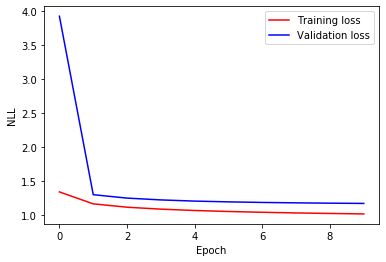

In [12]:
import warnings
warnings.filterwarnings("ignore")
import torch.optim as optim

# Train with cross entropy and at the end evaluate perplexity, similar to an accuracy measure

# Hyper-parameters
num_epochs = 10
batch_size = 32
# Initialize a new network
net = Net()
net = net.cuda()

# Define a loss function and optimizer for this problem
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0003) # ,weight_decay=0.001)
#optimizer = optim.SGD(net.parameters(), lr=0.00001)

# Track loss
training_loss, validation_loss, BPC = [], [], []

# For each epoch
for i in range(num_epochs):
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
        
    # For each sentence in validation set
    valid_sum=0
    net.eval()
    # print(hidden)
    for j,batch in enumerate(valid_iter):
        if j % 1000 ==0:
          print("batch: ", j , "out of ", len(valid_iter))
        text = batch.text.cuda()
        target = batch.target.cuda()
        # Forward pass

        
        outputs = net(text)
        
        target = target.view(-1).type(torch.cuda.LongTensor)
        loss = criterion(outputs, target)

        # Update loss
        epoch_validation_loss += loss.detach().cpu().data.numpy()


        #valid_sum+=loss
    
    net.train()
    # For each sentence in training set
    for j,batch in enumerate(train_iter):
        if j % 1000 ==0:
          print("batch: ", j, "out of ", len(train_iter))
        text = batch.text.cuda()
        target = batch.target.cuda()
                
        # Forward pass
        #text = text.t()
        target = target.view(-1).type(torch.cuda.LongTensor)
        outputs = net(text)
        
        # Compute loss
        loss = criterion(outputs, target)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update loss
        epoch_training_loss += loss.detach().cpu().data.numpy()

    
    # Save loss for plot
    training_loss.append(epoch_training_loss/len(train_iter))
    validation_loss.append(epoch_validation_loss/len(valid_iter))

    # Print loss every 5 epochs
    
    print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')

# Get first sentence in test set
#text, target = test_iter[1]

# One-hot encode input and target sequence
# inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
# targets_idx = [word_to_idx[word] for word in targets]

# Convert input to tensor
# inputs_one_hot = torch.Tensor(inputs_one_hot)
# inputs_one_hot = inputs_one_hot.permute(0, 2, 1)

# Convert target to tensor
# targets_idx = torch.LongTensor(targets_idx)

# Forward pass
# outputs = net.forward(text).cpu().data.numpy()

#print('\nInput sequence:')
#print(text)

#print('\nTarget sequence:')
#print(target)

#print('\nPredicted sequence:')
#print([idx_to_word[np.argmax(output)] for output in outputs])

# Plot training and validation loss
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

In [14]:
!nvidia-smi

Mon Dec  2 15:36:34 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    60W / 149W |   6708MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [13]:
# For each sentence in test set
test_sum=0
for j,batch in enumerate(test_iter):
    text = batch.text.cuda()
    target = batch.target.cuda()
    
    # Forward pass
    target = target.view(-1).type(torch.cuda.LongTensor)
    outputs = net(text)



    # Compute loss
    loss = criterion(outputs, target)
    
    # calculate softmax BPC
    #m = target.shape[0]
    #p = softmax(outputs.detach().cpu().data.numpy())
    #log_likelihood = -np.log2(p[range(m),target.detach().cpu().data.numpy()])
    #loss = np.sum(log_likelihood) / m

    test_sum += loss/np.log(2)

mean_sum=test_sum/len(test_iter)

BPC.append(mean_sum)
print(f'Epoch {i}, BPC: {BPC[-1]}')

Epoch 9, BPC: 1.529180645942688
